In [61]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

import sklearn.cluster
import sklearn.neighbors
import scipy

import hdbscan
import umap

In [ ]:
# df = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv')
# df = clean_data.filter_cleaned_trips(df)
# print(df.shape)
grid_points, grid_dict = clean_data.load_gridpts('road_backbone_coarse', 'grid_rte_ids_coarse')

In [ ]:
# a = rts_at_grid#pd.read_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')
# print(a.shape)
# a.head()
grid_points.rename(columns={'grid_i': 'grid_id'}, inplace=True)
grid_points.head()
# df.rename(columns={'id': 'rte_id'}, inplace=True)
# df.reset_index(inplace=True)
# df.tail()
len(grid_dict)

In [ ]:
rts.head()

In [ ]:
# Feather everything!
# df.to_feather(config.PROCESSED_DATA_PATH + 'trips.feather')
# grid_points.to_feather(config.MODEL_PATH + 'grid_points_fine.feather')
# rts_at_grid.to_feather(config.MODEL_PATH + 'rtes_at_grid_fine.feather')
# rts.to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_fine.feather')
grid_points.to_feather(config.MODEL_PATH + 'grid_points_coarse.feather')
rts_at_grid.to_feather(config.MODEL_PATH + 'rtes_at_grid_coarse.feather')
rts.to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_coarse.feather')

In [ ]:
# rts_at_grid.rte_ids.apply(len).describe()
# rts_at_grid.rte_ids.apply(len).describe()
# rts_at_grid.grid_id.max()
rts.head()

In [ ]:
rte_dict = collections.defaultdict(list)
for grid_id, rte_set in grid_dict.items():
    for rte_id in rte_set:
        rte_dict[rte_id] += [grid_id]

In [ ]:
rts_at_grid = []
for k, v in grid_dict.items():
    rts_at_grid += [{'grid_id': k, 'rte_ids': list(v)}]
rts_at_grid = pd.DataFrame(rts_at_grid)#.set_index('grid_id')
# rts_at_grid.to_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')

In [ ]:
rts = []
for k, v in rte_dict.items():
    rts += [{'rte_id': k, 'grid_ids': list(v)}]
rts = pd.DataFrame(rts)#.set_index('rte_id')
# rts.to_csv(config.MODEL_PATH + 'rts_grid_pts.csv')

In [ ]:
a = pd.read_feather('../EasyRider-Deployment/data/processed/rts_grid_pts.feather')
a.shape

In [ ]:
# grid_points.grid_id.max()

In [ ]:
# rts_at_grid.rte_ids = rts_at_grid.rte_ids.apply(lambda x: list(x))
# rts_at_grid.rte_ids[0]
rts_at_grid.shape

In [ ]:
rts_at_grid.to_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')

In [ ]:
# gp = grid_points.set_index('grid_i')
rts_gridpts = pd.read_csv(config.MODEL_PATH + 'rts_grid_pts.csv', index_col=0)
rts_at_grid = pd.read_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv', index_col=0)

rts_gridpts.grid_pts = rts_gridpts.grid_pts.apply(lambda x: [int(a) for a in x.strip('[]').split(',')])
rts_at_grid.rte_ids = rts_at_grid.rte_ids.apply(lambda x: set([int(a) for a in x.strip('{}').split(',')]))

In [62]:

type(rts_at_grid.loc[8229794].rte_ids)

NameError: name 'rts_at_grid' is not defined

In [ ]:
locs = gp.loc[rts.loc[11439445].grid_pts][['lat', 'lon']]
plt.plot(locs.lon, locs.lat, 'k.')

In [ ]:
colours = sns.color_palette('husl', 5)
[x * 255 for x in colours[0]]

In [ ]:
ride_points = locs
map_lims = np.array([[90, -90, 180, -180]])
map_lims = np.vstack((map_lims, 
                    np.array([[ride_points.lat.min(),
                               ride_points.lat.max(),
                               ride_points.lon.min(),
                               ride_points.lon.max()]])))
print(tuple(map_lims[:, 1:4:2].max(axis=0)))
tuple(map_lims[:, 0:3:2].min(axis=0))

## Deduping proper

In [63]:
## Make dataframe with rows of rte_id, columns of grid_ids
# Where 1 means that rte goes through that grid point, 0 not

# Load data
pts_per_degree = 25
grid_pts = pd.read_feather(config.MODEL_PATH + 'grid_points_{}.feather'.format(pts_per_degree))
rtes_at_grid = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_{}.feather'.format(pts_per_degree))
gridpts_at_rte = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_{}.feather'.format(pts_per_degree))

rtes_at_grid.set_index('grid_id', inplace=True)
gridpts_at_rte.set_index('rte_id', inplace=True)

In [ ]:
import pandas as pd
from util import config

In [ ]:
rte_grid_ohe.head(10)

In [ ]:
rte_grid_ohe.dtypes

In [44]:
rte_grid_ohe = gridpts_at_rte.copy()
rte_grid_ohe.drop('grid_ids', axis=1, inplace=True)
# rte_grid_ohe.loc[rtes_at_grid.loc[46333].rte_ids].shape

for i, grid_id in enumerate(rtes_at_grid.index.tolist()):
    if not i % 200: print(i)
    rte_grid_ohe[grid_id] = False
    rte_grid_ohe.loc[rtes_at_grid.loc[grid_id].rte_ids, grid_id] = True

a = dict()
for gi in rte_grid_ohe.columns:
    a[gi] = str(gi)
rte_grid_ohe.rename(columns=a).reset_index().to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_{}_ohe.feather'.format(pts_per_degree))

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800


In [68]:
rte_grid_ohe = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_{}_ohe.feather'.format(pts_per_degree))
rte_grid_ohe.set_index('rte_id', inplace=True)
rte_grid_ohe.shape

(20877, 1455)

In [ ]:
sdf = rte_grid_ohe.astype(pd.SparseDtype("bool", False))
rte_grid_ohe.head()

In [ ]:
print(rte_grid_ohe.shape[0] * rte_grid_ohe.shape[1])
rte_grid_ohe.values.sum().sum()

In [73]:
sda = scipy.sparse.csr_matrix(rte_grid_ohe.values)
sda.nnz
# sdf.sparse.density
# sda = pd.arrays.SparseArray(rte_grid_ohe, fill_value=False)
# rte_grid_ohe.values

225448

In [74]:
clusterer = sklearn.cluster.DBSCAN(min_samples=2, eps=0.5)
clusterer.fit(sda)

DBSCAN(min_samples=2)

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1) 
                              #min_cluster_size=100,
                              #min_samples=1,
                              #cluster_selection_epsilon=0.)
clusterer.fit(sda)

HDBSCAN(min_cluster_size=2, min_samples=1)

In [22]:
rte_grid_ohe.head()

,2882,2957,2735,2580,2655,2656,2810,2659,2369,2370,...,2460,2535,2609,2610,2684,2758,2759,2833,2907,3351
rte_id,,,,,,,,,,,,,,,,,,,,,
7118848,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3037186,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16773124,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23586828,True,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
44120078,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
reducer = umap.UMAP().fit_transform(sda)
xu = reducer[:, 0]
yu = reducer[:, 1]

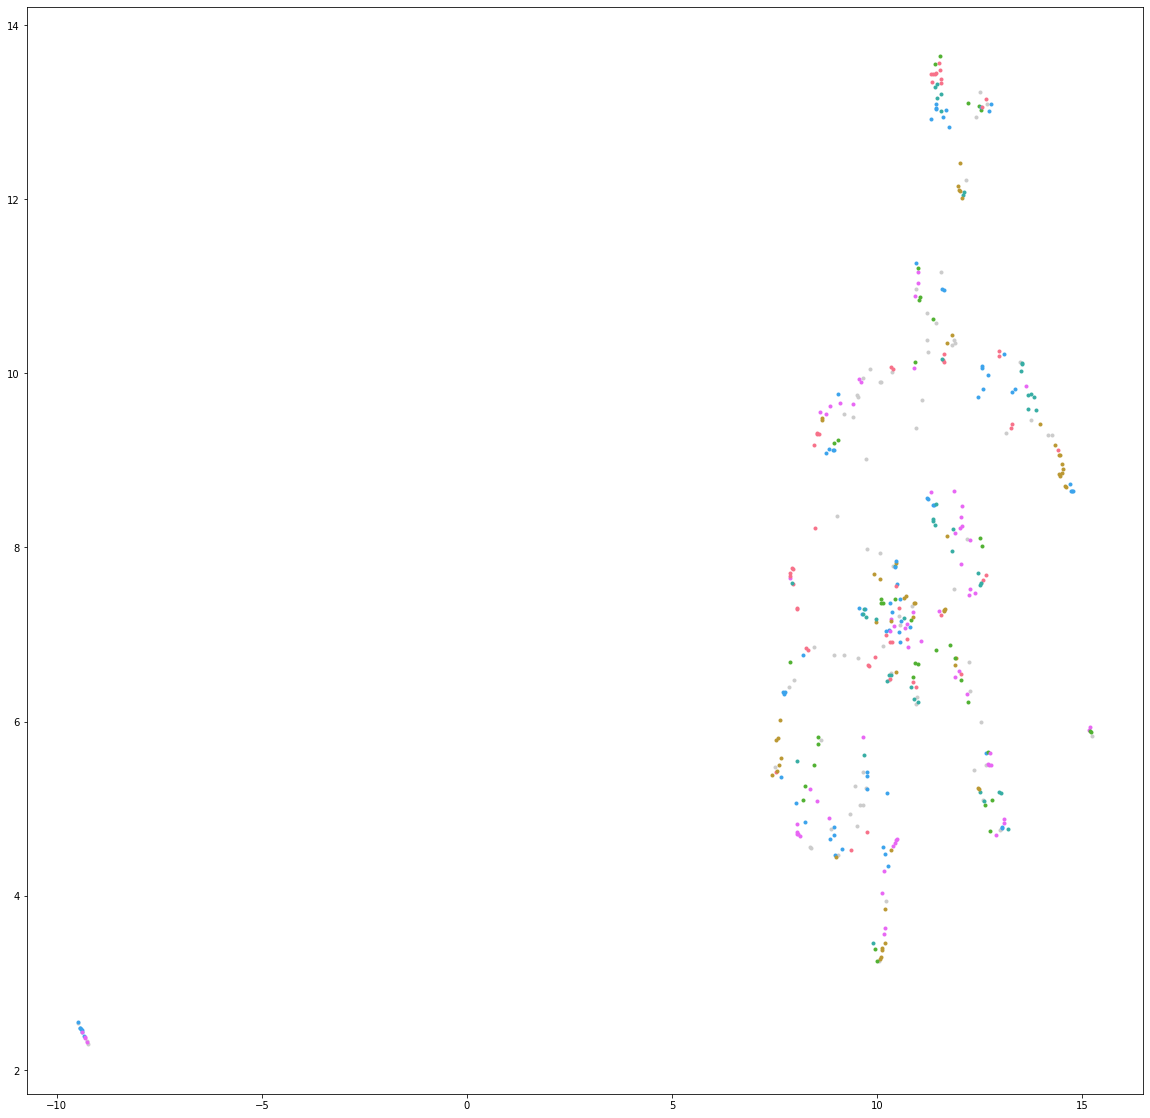

In [40]:
labels = clusterer.labels_
plt.figure(figsize=(20, 20))
for c in lab_counts.label:
    if c == -1: 
        plt.plot(xu[labels == c], yu[labels==c], '.', color=(0.8, 0.8, 0.8))
        continue
        
    plt.plot(xu[labels == c], yu[labels == c], '.')

In [75]:
rte_clustered = gridpts_at_rte.copy()
rte_clustered['labels'] = clusterer.labels_
lab_counts = rte_clustered.labels.value_counts().reset_index().rename(
    columns={'index': 'label', 'labels': 'n_rtes'})
lab_counts.head()

,label,n_rtes
0,-1,5405
1,606,195
2,1382,193
3,1283,114
4,1631,110


In [21]:
rte_ids = rte_grid_ohe[clusterer.labels_ == 2063].index.tolist()
rte_ids

[32387099,
 43436082,
 53211196,
 40425557,
 34291826,
 21194883,
 35145862,
 40880294,
 18430121,
 6017249,
 34762991,
 10649846,
 18686207,
 52060449,
 36804903,
 12863786,
 18594094,
 53207371,
 37439840,
 3666273,
 6650239,
 9724306,
 53311918,
 53000647,
 2296298,
 16593404,
 41435646,
 53553673,
 10461777,
 26380904,
 19012201,
 40714860,
 10341008,
 11563664,
 19858072,
 37870250,
 50404119,
 50404128,
 53214007,
 18535239,
 1772376,
 34466669,
 34466675,
 9907073,
 39160726,
 50492314,
 54999963,
 38513605,
 3584966,
 32252875,
 16421847,
 52153335,
 36355114,
 35226676,
 52802621,
 5858379,
 3699799,
 53210219,
 32197759,
 16868489,
 17712286,
 16964783,
 4205764,
 3640517,
 36005065,
 37436626,
 15963349,
 15963352,
 31886576,
 49710329,
 28220665,
 42640650,
 26987786,
 20102455,
 34565443,
 5535071,
 51903860,
 47756689,
 52196766,
 52905385,
 25019850,
 52030998,
 6970938,
 17239638,
 14014044,
 10782315,
 28382837,
 10782326,
 18413176,
 17172107,
 51941018,
 15584930,
 5

In [ ]:
rte_clustered.reset_index().to_feather(config.MODEL_PATH + 'rts_clustered_{}.feather'.format(pts_per_degree))

In [ ]:
gridpts_at_rte_fine.head()

In [23]:
def get_lat_lons_of_route(rte_id, gridpts, gridpts_rte):
    grid_inds = gridpts_rte[gridpts_rte.rte_id == rte_id].grid_ids.values[0].tolist()
    a = gridpts.set_index('grid_id')
    return a.loc[grid_inds].lat, a.loc[grid_inds].lon

In [22]:
grid_pts_fine = pd.read_feather(config.MODEL_PATH + 'grid_points_fine.feather')
gridpts_at_rte_fine = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_fine.feather')
grid_pts_75 = pd.read_feather(config.MODEL_PATH + 'grid_points_75.feather')
gridpts_at_rte_75 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_75.feather')


In [ ]:
# lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
grid_inds = gridpts_at_rte_fine[gridpts_at_rte_fine.rte_id == rte_id].grid_ids.values[0].tolist()
a = grid_pts_fine.reset_index()
a.head()#loc[grid_inds]

In [ ]:
print(rte_clustered[rte_clustered.labels == 2822].index[0])
rte_clustered.head()

In [ ]:
RTE_IDS = rte_clustered[rte_clustered.labels == -1].index.tolist()
for lab in lab_counts.label:
    if lab == -1: continue
    RTE_IDS += [rte_clustered[rte_clustered.labels == lab].index[0]]

In [ ]:
RTE_IDS.index()

In [ ]:
a = pd.DataFrame(pd.Series(RTE_IDS, dtype='int', name='rte_id'))
a.to_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')

In [ ]:
plt.figure(figsize=(10, 10))
for rte_id in RTE_IDS:
    lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, 'k.', markersize=0.005)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts_fine.lon, grid_pts_fine.lat, 'k.', markersize=0.1)
lab = -1
for rte_id in rte_clustered[rte_clustered.labels == lab].index.tolist():
    lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, linestyle='', markersize=0.25, marker='.')
for lab in lab_counts.label:
    if lab == -1: continue
    lats, lons = get_lat_lons_of_route(rte_clustered[rte_clustered.labels == lab].index[0],
                                      grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, linestyle='', markersize=0.25, marker='.')
# plt.xlim([-74.8, -73.2])
# plt.ylim([41., 42.6])

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=1/25*100)

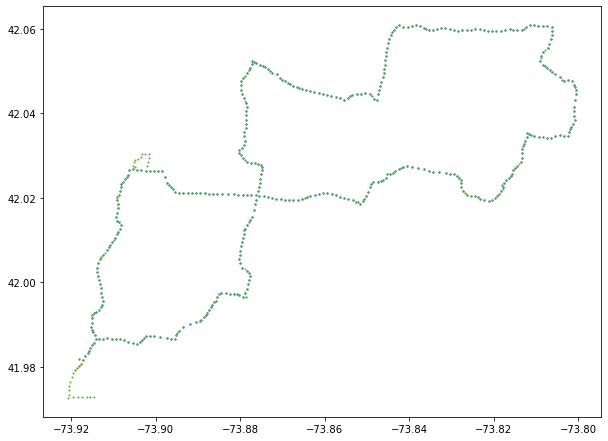

In [52]:
plt.figure(figsize=(10, 10))
# plt.plot(grid_pts_fine.lon, grid_pts_fine.lat, 'k.', markersize=0.5)
# plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=5)
labs = [13] #[2811, 2913, 1846, 2063, 2095]
sns.set_palette('husl')
for lab in labs:
    for rte_id in rte_clustered[rte_clustered.labels == lab].index.tolist():
        lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
        plt.plot(lons, lats, linestyle='', markersize=2, marker='.')
# plt.xlim([-73.95, -73.8])
# plt.ylim([41.69, 41.86])
plt.gca().set_aspect('equal')
    

In [8]:
lab_counts['n_sets'] = 0
for i, row in lab_counts.iterrows():
    lab = row.label
    grid_ids = rte_clustered[rte_clustered.labels == lab].grid_ids.values.tolist()
    lab_counts.at[i, 'n_sets'] = len(set(tuple(gi for gi in rt) for rt in grid_ids))
#     break
# lab_counts[lab_counts.n_rtes > 100].label.tolist()
# plt.plot(grid_pts.loc[])
# rte_ids = rte_clustered[rte_clustered.labels]

In [33]:
lab_counts[5 < lab_counts.n_sets].tail(10)
# lab = 288
# a = rte_clustered[rte_clustered.labels == lab].grid_ids

,label,n_rtes,n_sets
610,283,6,6
611,41,6,6
620,1768,6,6
640,3090,6,6
673,2964,6,6
695,445,6,6
699,1311,6,6
702,1716,6,6
703,301,6,6
710,288,6,6


<AxesSubplot:>

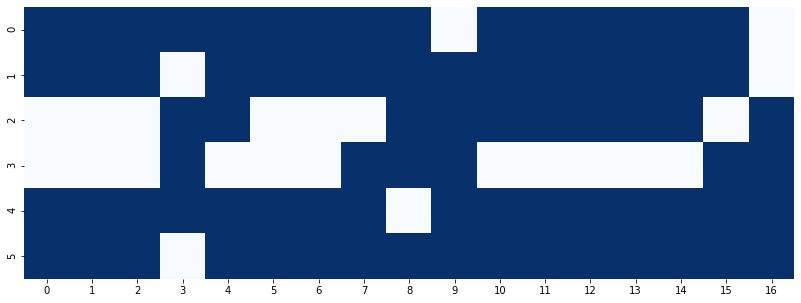

In [34]:
lab = 1311
a = rte_clustered[rte_clustered.labels == lab].grid_ids

gi = [g for i in a for g in i]
gi = set(gi)
b = pd.DataFrame(index=a.index)
for i, g in enumerate(gi):
    b[i] = a.apply(lambda x: g in x)
b.reset_index(drop=True, inplace=True)
# for i, r in b.iterrows():
#     plt.plot(np.arange(0+i/b.shape[0], 50+i/b.shape[0]), r, 'o')
# plt.plot(np.sum(b.values.astype(int), axis=0))
sns.set_palette('dark')

plt.figure(figsize=(20, 5))
sns.heatmap(b.values.astype(int), cbar=False, square=True, cmap="Blues_r")

Text(0, 0.5, 'Unique sets of grid points in cluster')

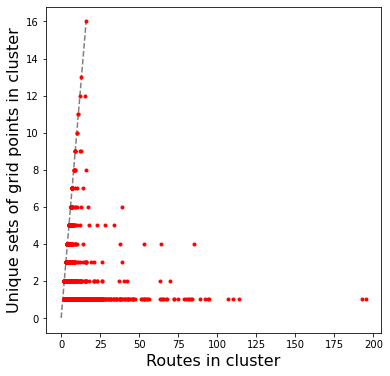

In [9]:
plt.figure(figsize=(6, 6))
plt.plot([0, 16], [0, 16], '--', color=(0.5, 0.5, 0.5))
plt.plot(lab_counts[lab_counts.label >= 0].n_rtes, lab_counts[lab_counts.label >= 0].n_sets, 'r.')
ftsz = 16
plt.xlabel('Routes in cluster', fontsize=ftsz)
plt.ylabel('Unique sets of grid points in cluster', fontsize=ftsz)

# plt.gca().set_fontsize(16)

In [ ]:
te_clustered.reset_index().to_feather(config.MODEL_PATH + 'rts_clustered_{}.feather'.format(pts_per_degree))